# Language Processing

## Load Libraries

In [ ]:
import re
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch

import os
import csv

import random

import matplotlib.pyplot as pyplot

## Pre-Processing

In [2]:
TRAIN_FILENAME = '../dataset/train.csv'
TEST_FILENAME = '../dataset/test.csv'
IMAGE_DIRECTORY = "../dataset/images"
DATA_BASEPATH = "../dataset"

def append_none_to_caption(df: pd.DataFrame) -> pd.DataFrame:
    caption_col = "Caption"
    extra_col = None
    sep = " "

    if extra_col is None:
        if None in df.columns:
            extra_col = None
        elif 'None' in df.columns:
            extra_col = 'None'
        else:
            raise KeyError("Could not find a column named None or 'None' in your DataFrame.")

    # make sure captions are strings
    df[caption_col] = df[caption_col].astype(str)

    # build a Series of the extra text, safely capturing sep in the lambda’s default
    extras = df[extra_col].apply(
        lambda val, sep=sep: (
            '' if pd.isna(val)
            else sep.join(str(item).strip() for item in (val if isinstance(val, (list, tuple)) else [val]))
        )
    )

    # only append where there actually is some extra text
    mask = extras.ne('')
    df.loc[mask, caption_col] = df.loc[mask, caption_col] + sep + extras[mask]

    return df.drop(columns=[extra_col])

def extract_df(filename):
    path = os.path.join(DATA_BASEPATH, filename)
    with open(path, newline="", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile, delimiter=",", quotechar='"', escapechar="\\")
        df = pd.DataFrame(reader)

    return append_none_to_caption(df)

train_data = extract_df(TRAIN_FILENAME)
test_data = extract_df(TEST_FILENAME)
train_data

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


In [3]:
def GetWordDictionary(datasets):
    words = []
    for dataset in datasets:
        for caption in dataset['Caption']:
            strippedCaption = re.sub('[^A-Za-z0-9 ]+', '', caption).lower()
            words.extend(strippedCaption.split())

    wordSet = set(words)
    wordDict = {}
    i = 1
    for word in wordSet:
        wordDict[word] = i
        i+=1
    
    return wordDict

wordDict = GetWordDictionary([train_data, test_data])

In [4]:
def AddTokenColumn(dataframe):
    tokenColumn = []
    for caption in dataframe['Caption']:
        tokens = []
        strippedCaption = re.sub('[^A-Za-z0-9 ]+', '', caption).lower()
        for word in strippedCaption.split():
            tokens.append(wordDict[word])
        
        tokenColumn.append(tokens)
        
    dataframe['tokenized-caption'] = tokenColumn

def AddOneHotLabelColumn(dataframe):
    labelColumn = []
    for labels in dataframe['Labels']:
        oneHotLabels = [0] * 19
        splitLabels = labels.split()
        for label in splitLabels:
            oneHotLabels[int(label)-1] = 1.0
        labelColumn.append(list(oneHotLabels))
    dataframe['one-hot-labels'] = list(labelColumn)
    
AddTokenColumn(train_data)
AddTokenColumn(test_data)
AddOneHotLabelColumn(train_data)

## Batching

In [5]:
def GetBatches(data, labels, batch_size=128):
    indexList = list(range(0, len(data)))
    random.shuffle(indexList)
    
    batchedData = []
    batchedLabels = []
    
    currentDataBatch = []
    currentLabelBatch = []
    
    currentDataBatch.append(torch.tensor(data[indexList[0]]))
    currentLabelBatch.append(labels[indexList[0]])
    i = 1
    while i < len(data):
        if i % batch_size == 0:
            batchedData.append(currentDataBatch)
            batchedLabels.append(currentLabelBatch)
            currentDataBatch = []
            currentLabelBatch = []
        currentDataBatch.append(torch.tensor(data[indexList[i]]))
        currentLabelBatch.append(labels[indexList[i]])
    
        
        i+=1
        
    return batchedData, batchedLabels

## Model

In [6]:
vocabSize = len(wordDict.keys())+1
LEARNING_RATE = .001
BATCH_SIZE = 128
EPOCHS = 15
EMBEDDING_DIM = 20

In [7]:
class LSTMNetwork(nn.Module):
    def __init__(self, embeddingDimensions, hiddenDimensions, vocabSize, numLabels, numLstmLayers, dropout=.2):
        super(LSTMNetwork, self).__init__()

        self.embeddingLayer = nn.Embedding(vocabSize+1, embeddingDimensions)

        self.lstmLayer = nn.LSTM(embeddingDimensions, hiddenDimensions, numLstmLayers, dropout=dropout, batch_first=True)
        self.linearLayer = nn.Linear(hiddenDimensions, numLabels)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sentences):
        paddedSequences = nn.utils.rnn.pad_sequence(sentences, batch_first=True)
        sequenceLengths = torch.tensor([len(seq) for seq in sentences])
        
        embeds = self.embeddingLayer(paddedSequences)
        
        packedEmbedding = nn.utils.rnn.pack_padded_sequence(embeds, sequenceLengths.cpu(), batch_first=True, enforce_sorted=False)
        _packedLstmOutput, (hidden, _cell) = self.lstmLayer(packedEmbedding)
        
        output = self.linearLayer(hidden[-1])
        return self.sigmoid(output)

model = LSTMNetwork(EMBEDDING_DIM, 128, vocabSize, 19, 2)

## Training

### Validation Helper Functions

While we arent using these yet, they will be important once we start tuning our parameters and I would rather not repeat the training loop code

#### Getting Accuracy

In [8]:
def GetAccuracy(predictions, labels, cutoff=.5):
    j=0
    total = 0
    truePredictions = 0
    while j < len(predictions):
        isMatch = GetMatch(predictions[j], labels[j], cutoff)
        if(isMatch):
            truePredictions +=1
        total +=1
        j+=1
    return truePredictions/ total

def GetMatch(prediction, trueLabel, cutoff=.5):
    match = True
    i = 0
    while i < len(trueLabel):
        if trueLabel[i] == 1.0:
            if prediction[i] < cutoff:
                match = False
        else:
            if prediction[i] > cutoff:
                match = False
        i+=1
    
    return match

### Calculate Precision

In [9]:
def getPrecision(predictions, labels, cutoff=.5):
    truePositives = [0] * 19
    falsePositives = [0] * 19
    
    #print(predictions[0])
    #print(labels[0])
    i = 0
    while i < len(predictions):
        prediction = predictions[i]
        label = labels[i]
        
        j = 0
        while j < len(prediction):
            if prediction[j] > cutoff and label[j] == 1.0:
                truePositives[j] += 1
            elif prediction[j] > cutoff and label[j] != 1.0:
                falsePositives[j] += 1
            j+=1
        i+=1
    
    totalPrecisionScore = 0
    i = 0
    while i < len(truePositives):
        if (truePositives[i] + falsePositives[i]) == 0:
            totalPrecisionScore += 1
        else:
            totalPrecisionScore += truePositives[i] / (truePositives[i] + falsePositives[i])
        i+=1
    
    return totalPrecisionScore / 19

#### Getting Predictions

In [10]:
def GetPredictions(model, data):
    model.eval()
    predictions = []
    currentIndex = 0
    while currentIndex + BATCH_SIZE < len(data):
        predictions.extend(model(GetCaptionTensors(data[currentIndex: currentIndex+BATCH_SIZE])))
        currentIndex += BATCH_SIZE

    predictions.extend(model(GetCaptionTensors(data[currentIndex: len(data)])))
    return predictions

def GetCaptionTensors(data):
    tensors = []
    for datapoint in data:
        tensors.append(torch.tensor(datapoint))
        
    return tensors

### Training Loop

In [11]:
def train_loop(model, trainData: tuple, epochs=20, validationData= None, printUpdates= True):
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    model.train()

    i = 0
    while i < epochs:
        batchedData, batchedLabels = GetBatches(trainData[0],trainData[1])
        
        total_loss = 0

        j = 0 
        while j < len(batchedData):
            y_pred = model(batchedData[j])
            #print(y_pred)
            #print(batchedLabels[j])
            loss = loss_fn(y_pred, torch.tensor(batchedLabels[j]))
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            j+=1
            total_loss += loss.item()

        if printUpdates:
            avg_loss = total_loss / len(batchedData)
            print(f"Epoch {i+1}/{epochs} - Training Loss: {avg_loss:.4f}")
            
            if(validationData is not None):
                validationPredictions = GetPredictions(model, validationData[0])
                print("Validation Accuracy: ", GetAccuracy(validationPredictions, validationData[1], .6))
                print("Validation Precision: ", getPrecision(validationPredictions, validationData[1], .6))
                
            print("\n")
        i+=1
    
#train_loop(model, trainData=(train_data['tokenized-caption'], train_data['one-hot-labels']))

## Evaluation

### Hyper Parameter Tuning

In [12]:
def SplitTrainSet(data, percentSplit = .8):
    indexList = list(range(0, len(data)))
    random.shuffle(indexList)
    
    trainingSize = len(data) *  percentSplit
    
    i = 0
    trainingData = []
    trainingLabels = []
    while i < trainingSize:
        trainingData.append(data['tokenized-caption'][indexList[i]])
        trainingLabels.append(data['one-hot-labels'][indexList[i]])
        i+=1
    
    validationData = []
    validationLabels = []
    while i < len(data):
        validationData.append(data['tokenized-caption'][indexList[i]])
        validationLabels.append(data['one-hot-labels'][indexList[i]])
        i+=1
    
    return (trainingData, trainingLabels), (validationData, validationLabels)

In [ ]:
trainingSet, validationSet = SplitTrainSet(train_data)

embeddingDimensions = [16, 32, 64]
hiddenDimensions = [64, 128, 256]
numLSTMLayers = [1, 2] #3
dropouts=[0, .2, .4]

for embeddingDimension in embeddingDimensions:
    for hiddenDimension in hiddenDimensions:
        for numLSTMLayer in numLSTMLayers:
            for dropout in dropouts: 
                model = LSTMNetwork(embeddingDimension, hiddenDimension, vocabSize, 19, numLSTMLayer, dropout)
                train_loop(model, trainingSet, epochs=15, printUpdates=False)
                
                model.eval()
                validationPredictions = GetPredictions(model, validationSet[0])
                
                print("embedding Dimensions: %d \thidden Dimensions: %d \tLSTM Layers: %d\tdropout: %f" % (embeddingDimension, hiddenDimension, numLSTMLayer, dropout))
                print("90 percent certainty scores:")
                print("Validation Accuracy: ", GetAccuracy(validationPredictions, validationSet[1], .9))
                print("Validation Precision: ", getPrecision(validationPredictions, validationSet[1], .9))
                print("60 percent certainty scores:")
                print("Validation Accuracy: ", GetAccuracy(validationPredictions, validationSet[1], .6))
                print("Validation Precision: ", getPrecision(validationPredictions, validationSet[1], .6))
                print("\n")


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 1	dropout: 0.000000
90 percent certainty scores:
Validation Accuracy:  0.5316666666666666
Validation Precision:  0.9981811465308683
60 percent certainty scores:
Validation Accuracy:  0.6083333333333333
Validation Precision:  0.918915514002534




c:\Python311\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 1	dropout: 0.200000
90 percent certainty scores:
Validation Accuracy:  0.5251666666666667
Validation Precision:  0.9845597209614128
60 percent certainty scores:
Validation Accuracy:  0.6028333333333333
Validation Precision:  0.944236874261865




c:\Python311\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 1	dropout: 0.400000
90 percent certainty scores:
Validation Accuracy:  0.5161666666666667
Validation Precision:  0.9977221485383102
60 percent certainty scores:
Validation Accuracy:  0.6125
Validation Precision:  0.9458050532210625


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 2	dropout: 0.000000
90 percent certainty scores:
Validation Accuracy:  0.503
Validation Precision:  0.9977332063480736
60 percent certainty scores:
Validation Accuracy:  0.5831666666666667
Validation Precision:  0.9514828796126581


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 2	dropout: 0.200000
90 percent certainty scores:
Validation Accuracy:  0.5521666666666667
Validation Precision:  0.9968606150077234
60 percent certainty scores:
Validation Accuracy:  0.6268333333333334
Validation Precision:  0.9472278754690855


embedding Dimensions: 16 	hidden Dimensions: 64 	LSTM Layers: 2	dropout: 0.400000
90 percent certaint

### Train Hyper Tuned model on full dataset

In [159]:
model = LSTMNetwork(32, 256, vocabSize, 19, 2, .2)
train_loop(model, (train_data['tokenized-caption'], train_data['one-hot-labels']), epochs=15, printUpdates=True)
                
model.eval()

Epoch 1/15 - Training Loss: 0.2069


Epoch 2/15 - Training Loss: 0.1907


Epoch 3/15 - Training Loss: 0.1682


Epoch 4/15 - Training Loss: 0.1436


Epoch 5/15 - Training Loss: 0.1216


Epoch 6/15 - Training Loss: 0.1069


Epoch 7/15 - Training Loss: 0.0964


Epoch 8/15 - Training Loss: 0.0898


Epoch 9/15 - Training Loss: 0.0852


Epoch 10/15 - Training Loss: 0.0815


Epoch 11/15 - Training Loss: 0.0782


Epoch 12/15 - Training Loss: 0.0750


Epoch 13/15 - Training Loss: 0.0719


Epoch 14/15 - Training Loss: 0.0685


Epoch 15/15 - Training Loss: 0.0645




LSTMNetwork(
  (embeddingLayer): Embedding(8152, 32)
  (lstmLayer): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.2)
  (linearLayer): Linear(in_features=256, out_features=19, bias=True)
  (sigmoid): Sigmoid()
)

### Get Test Predictions

In [160]:
model.eval()
predictions = GetPredictions(model, test_data['tokenized-caption'])

In [161]:
def FormatPredictions(predictions, cutoff):
    formattedPredictions = []
    for prediction in predictions:
        formattedPrediction = []
        i = 0
        while i < len(prediction):
            if(prediction[i] > cutoff):
                formattedPrediction.append(i+1)
                
            i+=1
            
        formattedPredictions.append(formattedPrediction)
    return formattedPredictions


formattedPredictions = FormatPredictions(predictions, .9)

### Write out results

In [162]:
with open('out.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(formattedPredictions)

In [163]:
torch.save(model.state_dict(), './model')

### Graphs

In [19]:
def plotMetrics(accuracies, precisions, name, cutoffs):
    pyplot.suptitle('accuracy and precision based on certainty cutoff')
    pyplot.title(name)
    pyplot.plot(cutoffs, accuracies)
    pyplot.plot(cutoffs, precisions)
    pyplot.xlabel('cutoff for positive labeling')
    pyplot.ylabel('score')
    pyplot.legend(['accuracy', 'precision'], loc='upper left')
    pyplot.grid(True)
    pyplot.show()
    

#### Large Model

Epoch 1/15 - Training Loss: 0.2123
Validation Accuracy:  0.4671666666666667
Validation Precision:  0.9873333333333334


Epoch 2/15 - Training Loss: 0.1912
Validation Accuracy:  0.4671666666666667
Validation Precision:  0.9873333333333334


Epoch 3/15 - Training Loss: 0.1910
Validation Accuracy:  0.4671666666666667
Validation Precision:  0.9873333333333334


Epoch 4/15 - Training Loss: 0.1813
Validation Accuracy:  0.44783333333333336
Validation Precision:  0.995685731742291


Epoch 5/15 - Training Loss: 0.1560
Validation Accuracy:  0.4578333333333333
Validation Precision:  0.9954797112621768


Epoch 6/15 - Training Loss: 0.1328
Validation Accuracy:  0.5241666666666667
Validation Precision:  0.9917646181680047


Epoch 7/15 - Training Loss: 0.1152
Validation Accuracy:  0.5651666666666667
Validation Precision:  0.9585420419325686


Epoch 8/15 - Training Loss: 0.1031
Validation Accuracy:  0.5886666666666667
Validation Precision:  0.9546333308565099


Epoch 9/15 - Training Loss: 0.0945
Valid

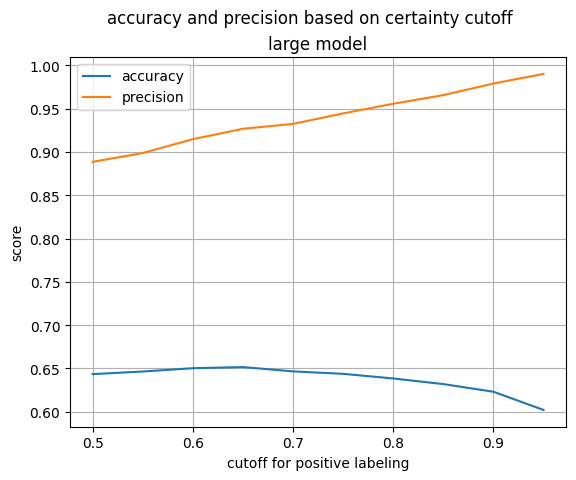

In [21]:
trainingSet, validationSet = SplitTrainSet(train_data)
graphModel = LSTMNetwork(32, 256, vocabSize, 19, 2, .2)
train_loop(graphModel, trainingSet, epochs=15, validationData=validationSet)

cutoffs = [.5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
accuracies = []
precisions = []

predictions = GetPredictions(graphModel, validationSet[0])

for cutoff in cutoffs:
    accuracies.append(GetAccuracy(predictions, validationSet[1], cutoff))
    precisions.append(getPrecision(predictions, validationSet[1], cutoff))

plotMetrics(accuracies, precisions, "large model",cutoffs)

#### Small Model

c:\Python311\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/15 - Training Loss: 0.2591
Validation Accuracy:  0.46316666666666667
Validation Precision:  0.9872940102841298


Epoch 2/15 - Training Loss: 0.1855
Validation Accuracy:  0.46316666666666667
Validation Precision:  0.9873392106142991


Epoch 3/15 - Training Loss: 0.1734
Validation Accuracy:  0.45466666666666666
Validation Precision:  0.9920497446147012


Epoch 4/15 - Training Loss: 0.1623
Validation Accuracy:  0.44716666666666666
Validation Precision:  0.9959756774486552


Epoch 5/15 - Training Loss: 0.1506
Validation Accuracy:  0.4528333333333333
Validation Precision:  0.9777926808268237


Epoch 6/15 - Training Loss: 0.1415
Validation Accuracy:  0.4555
Validation Precision:  0.9764445765337367


Epoch 7/15 - Training Loss: 0.1344
Validation Accuracy:  0.4648333333333333
Validation Precision:  0.9745252637139954


Epoch 8/15 - Training Loss: 0.1273
Validation Accuracy:  0.48433333333333334
Validation Precision:  0.9731193723303465


Epoch 9/15 - Training Loss: 0.1198
Validation A

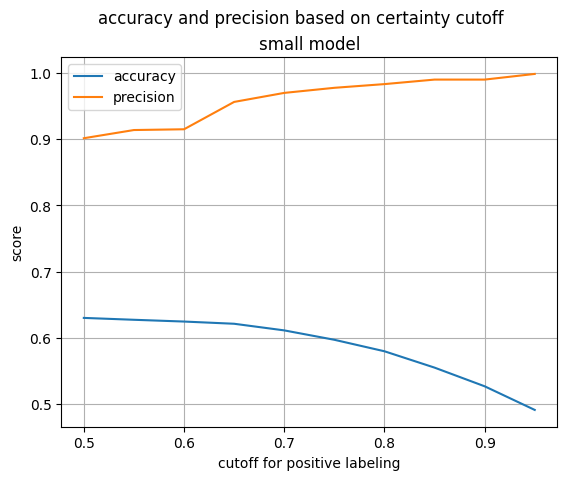

In [22]:
trainingSet, validationSet = SplitTrainSet(train_data)
graphModel = LSTMNetwork(32, 64, vocabSize, 19, 1, .2)
train_loop(graphModel, trainingSet, epochs=15, validationData=validationSet)

cutoffs = [.5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
accuracies = []
precisions = []

predictions = GetPredictions(graphModel, validationSet[0])

for cutoff in cutoffs:
    accuracies.append(GetAccuracy(predictions, validationSet[1], cutoff))
    precisions.append(getPrecision(predictions, validationSet[1], cutoff))

plotMetrics(accuracies, precisions, "small model",cutoffs)